<a href="https://colab.research.google.com/github/alanbseo/MFAworkshop/blob/main/MFA_2_MaterialIntensity_EmbeddedCarbon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이 노트북에서는 지난 번 코드에서 전처리한 자료를 읽어서 MI와 Embedded Carbon을 계산해 보도록 합시다.

## Colab 기본 설정


In [94]:
# import packages
import os
import matplotlib.pyplot as plt
import numpy as np


# import pandas and geopandas package
import pandas as pd

try:
  import geopandas as gpd
except: # 설치되어 있지 않을 경우 이리로 분기하여 패키지를 설치
  !pip install geopandas 
  import geopandas as gpd

# import rasterio pacakge 
try:
  import rasterio
except:
  !pip install rasterio
  import rasterio

# import required functions
from rasterio import transform
from rasterio import features
from rasterio.enums import Resampling


In [95]:
from google.colab import drive

# Mount Gdrive 
# 이번에는 이미 마운트 되어 있는지 확인하고 
if not (os.path.exists('/content/gdrive/')):
  print("Mount Gdrive")
  drive.mount('/content/gdrive/') # 마운트 되어있지 않을 때만 다시 시도


# set working directory
default_path = '/content/gdrive/MyDrive/Net zero built environment/MFA workshop' # 이 경로는 사용자 마다 상이할 수 있음
 
print("Change working directory to the Google Drive folder")
os.chdir(default_path) 
print(os.getcwd()) # print the current working directory


Change working directory to the Google Drive folder
/content/gdrive/.shortcut-targets-by-id/1gDT-7hKMl37JnTVecJLmI9yB2rUI7rAo/Net zero built environment/MFA workshop


## 지난 시간에 만든 건축물 용적(volume)과 구조코드를 읽어들이자. 

In [96]:
# Read the rasterised Volume and Code data 
volume_out_fn = './images/volume_100m.tif'
code_out_fn = './images/code_100m.tif'


# 해당 파일이 없을 경우 에러가 발생하고, 그럴 때는 images 폴더 안에 해당 파일을 복사해 넣어야 함. 
with rasterio.open(volume_out_fn) as src:
    print(src.__class__) 
    print(src.profile) # meta information 출력
    volume_img = src.read(1)  # 읽어들인 이미지는 rasterio 패키지의 DatasetReader클래스인데, 
                              # 우리는 ndarray 형태의 자료만 사용


with rasterio.open(code_out_fn) as src:
    print(src.profile)
    code_img = src.read(1) 



<class 'rasterio.io.DatasetReader'>
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 67, 'height': 75, 'count': 1, 'crs': CRS.from_epsg(5179), 'transform': Affine(100.0, 0.0, 951300.0,
       0.0, -100.0, 1959400.0), 'blockysize': 15, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 67, 'height': 75, 'count': 1, 'crs': CRS.from_epsg(5179), 'transform': Affine(100.0, 0.0, 951300.0,
       0.0, -100.0, 1959400.0), 'blockysize': 75, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [97]:
 ## Print the class name 
volume_img.__class__ #  ndarray object. 
# code_img.__class__ #   ndarray object. 
 

numpy.ndarray

Text(0, 0.5, 'Row #')

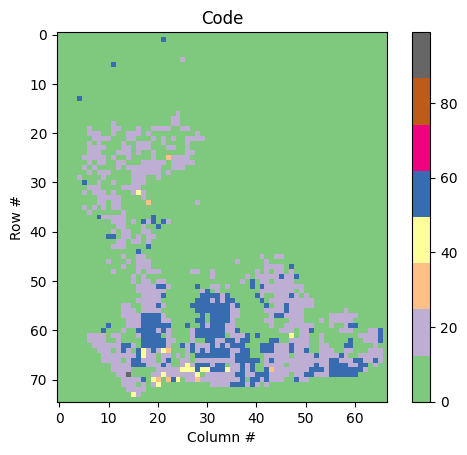

In [98]:
# plot the sturctural code data
plt.imshow(code_img, cmap='Accent')
plt.colorbar()
plt.title('Code')
plt.xlabel('Column #')
plt.ylabel('Row #')

In [99]:
# Dimension
code_img.shape  # 75 x 67 

# Frequency table
unique, counts = np.unique(code_img, return_counts=True)
print(dict(zip(unique, counts))) # 코드 별 빈도수. 1 ha 래스터 이니 그대로 ha로 볼 수도 있음. E.g. 676 ha = 6.76 km2

### 
# 0: NA
# 11: Brick
# 12: Block
# 19: Other masonry structure (기타조적구조)
# 21: Reinforced concrete
# 31: Steel (일반철골구조)
# 40: Steel reinforced concrete
# 41: Steel concrete (철골콘크리트)
# 42: Steel reinforced concrete (== 40?)
# 51: Wood (일반목구조)
# 99: Other 


{0: 3714, 11: 327, 12: 22, 19: 1, 21: 676, 31: 7, 40: 1, 41: 1, 42: 16, 51: 259, 99: 1}


구조 코드별로 건축물 용적을 나누고, MI 원단위를 적용.. 하려고 했는데 MI가 면적 단위인 것을 알게 됨. 

데이터에 연면적 자료가 있으니 다시 그것을 처리하도록 하자. 


In [100]:
# Gross area data for Jongno-gu (Feb 2023)
path_data_grossarea = "Data/Data_100m/Jongno-gu/(B100)국토통계_건축물-연면적-(격자) 100M_서울특별시 종로구_202303/nlsp_021002006.shp"
grossarea_gdf = gpd.read_file(path_data_grossarea, encoding = "UTF-8")
print(grossarea_gdf.columns) # 컬럼 이름 
print(grossarea_gdf.head()) # 이번 경우에는 lbl과 val에 같은 값이 들어있네요

Index(['gid', 'lbl', 'val', 'geometry'], dtype='object')
        gid      lbl      val  \
0  다사551532   120.21   120.21   
1  다사564526   610.47   610.47   
2  다사539568  2793.05  2793.05   
3  다사526570   458.74   458.74   
4  다사548528  1690.90  1690.90   

                                            geometry  
0  POLYGON ((955100.000 1953200.000, 955100.000 1...  
1  POLYGON ((956400.000 1952600.000, 956400.000 1...  
2  POLYGON ((953900.000 1956800.000, 953900.000 1...  
3  POLYGON ((952600.000 1957000.000, 952600.000 1...  
4  POLYGON ((954800.000 1952800.000, 954800.000 1...  


In [101]:
# Create a base 100 m grid 
dummy_shp = grossarea_gdf # 여기서 원본 데이터를 dummy에 할당, crs 정보도 옮겨옴
bbox = dummy_shp.total_bounds # 벡터 데이터의 바운딩 박스를 래스터 만들 때 쓰려고 bbox 변수에 할당
xmin, ymin, xmax, ymax = bbox # bbox의 정보를 4개의 double 변수에 옮김. 파이썬 스타일.. 
                              # 오른쪽 변수에서 리턴되는 값이 double형 네 개이고 그게 xmin 등 4개의 실수형 변수 값으로 됨

print(bbox.__class__) # Numpy N-d array 클래스이고
print(bbox.shape)     # 실수형 자료 4개를 가지고 있음
print(xmin.__class__) # 받은 xmin등은 Numpy Float64. 64비트 플로트 정수. Float는 Double 보다 메모리를 아껴서 저장하는 실수형 타입.. 

res = 100 # desired resolution
w = (xmax - xmin) // res 
h = (ymax - ymin) // res

# R에선 사실 
# raster_out = rasterize(polygon, dummy_raster_grid) 식으로 간단히 처리하는데, Python이
# 공간 자료 처리가 좀 더 low-level에서 적어줘야 하는 듯. 간단한 방식이 없는 듯.. 
# 아래와 같이 메타데이터 리스트를 만들어 주고.. 

# float type for continuous data
out_meta_float64 = {
    "driver": "GTiff",
    "dtype": "float64", # 64bit float
    "height": h,
    "width": w,
    "count": 1,
    "crs": dummy_shp.crs,
    "transform": transform.from_bounds(xmin, ymin, xmax, ymax, w, h),
    "compress": 'lzw'
}

grossarea_out_fn = './images/grossarea_100m.tif'
 
# 변환해서 파일에 쓰는 식으로 처리. 불필요하게 복잡한 감이 있다.. 이후 많이 사용하게 되면 함수화 해야 함.

# convert height
with rasterio.open(grossarea_out_fn, 'w+', **out_meta_float64) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(grossarea_gdf.geometry, grossarea_gdf.val))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)



<class 'numpy.ndarray'>
(4,)
<class 'numpy.float64'>


<open DatasetReader name='images/grossarea_100m.tif' mode='r'>


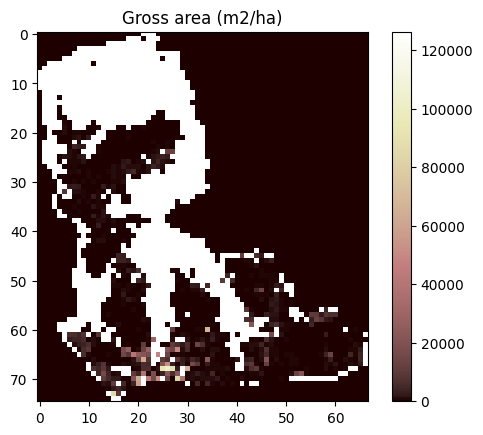

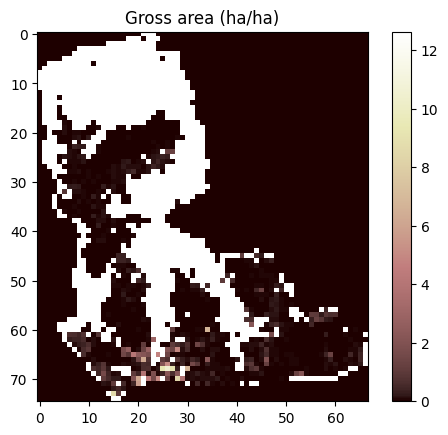

In [102]:
# read the outcome rasters
grossarea_100m_r = rasterio.open('images/grossarea_100m.tif')
print(grossarea_100m_r)

# Plot the image
grossarea_100m_img = grossarea_100m_r.read(1)
 
plt.imshow(grossarea_100m_img, cmap='pink')
plt.colorbar()
plt.title('Gross area (m2/ha)') # 이 데이터가 100 m * 100 m 래스터이기 때문에 단위는 m2/ha 
plt.show()  

plt.imshow(grossarea_100m_img / 1E4  , cmap='pink')
plt.colorbar()
plt.title('Gross area (ha/ha)') # ha/ha 로 해 봄
plt.show()  

In [103]:
# Gross-area by Structure
grossarea_21 = grossarea_100m_img * (code_img == 21) 

# sum 을 하면 에러.. nansum을 해야 nan 값을 제외하고 합산
print(np.nansum(grossarea_21)) # m2

print("Gross area (All structure) = " + str(np.nansum(grossarea_100m_img)/1E4) + " (ha)")  # total gross area (ha)
print("Gross area (Reinforced concerete; Code=21) = " + str(np.nansum(grossarea_21)/1E4) + " (ha)")  # only for Code=21 (ha)

 

1691338.2599999998
Gross area (All structure) = 315.53032 (ha)
Gross area (Reinforced concerete; Code=21) = 169.13382599999997 (ha


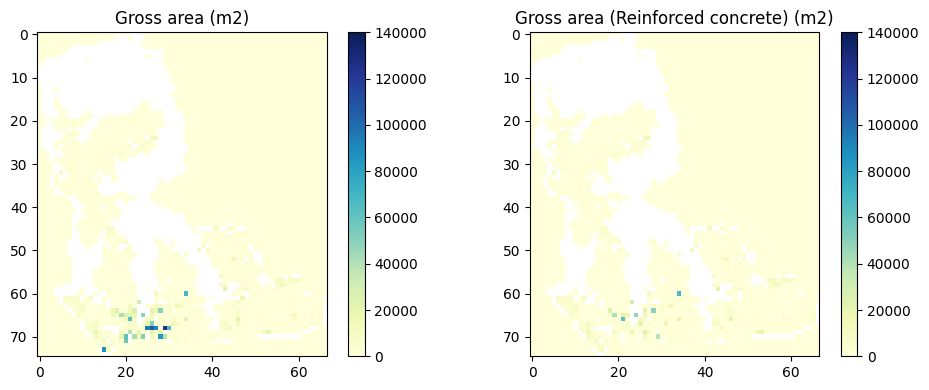

In [106]:
nrow = 1
ncol = 2


plt.figure(figsize=(10,4))
plt.subplot(nrow, ncol, 1)
plt.imshow(grossarea_100m_img,  cmap='YlGnBu', vmin=0, vmax=1.4E5)
plt.colorbar()
plt.title('Gross area (m2)')

plt.subplot(nrow, ncol, 2)
plt.imshow(grossarea_21,  cmap='YlGnBu', vmin=0, vmax=1.4E5)
plt.colorbar()
plt.title('Gross area (Reinforced concrete) (m2)')


plt.tight_layout()
plt.show()



In [107]:
# Read MI table

# 이름으로 불러오기
# pd.read_excel('경로/파일명.xlsx', sheet_name = '시트명')
MI_tb = pd.read_excel('Data/MI by structure_v1.xlsx', sheet_name = 'MI')
# MI_tb.head()
print(MI_tb) # R과 파이썬의 큰 차이중 하나는 R은 통계학자가 만들었다 보니 NA와 NaN의 구분이 명확. 파이썬은 좀 애매.. pandas에서 처리하긴 하는데 정확히 구분하지 않을 때가 많음. 
 

   Code                       Name  Brick_kgm2  Mortar_kgm2  Block_kgm2  \
0    11                      Brick       262.5       152.25         NaN   
1    12                      Block         NaN        49.35       525.0   
2    19    Other masonry structure         NaN          NaN         NaN   
3    21        Reinforced concrete         NaN          NaN         NaN   
4    31                      Steel         NaN          NaN         NaN   
5    40  Steel reinforced concrete         NaN          NaN         NaN   
6    41             Steel concrete         NaN          NaN         NaN   
7    42  Steel reinforced concrete         NaN          NaN         NaN   
8    51                       Wood         NaN          NaN         NaN   
9    99                      Other         NaN          NaN         NaN   

   Concrete_m3m2  Rebar_kgm2  SteelFrame_kgm2  StructuralMaterial_m3m2  \
0            NaN         NaN              NaN                      NaN   
1            NaN         N

In [108]:
MI_tb = MI_tb.fillna(0) # NaN을 0으로 바꿔주자
# 혹은 이런 식으로 컬럼마다 할 수도 있음
# MI_tb['DataFrame Column'] = MI_tb['DataFrame Column'].fillna(0)

print(MI_tb)


   Code                       Name  Brick_kgm2  Mortar_kgm2  Block_kgm2  \
0    11                      Brick       262.5       152.25         0.0   
1    12                      Block         0.0        49.35       525.0   
2    19    Other masonry structure         0.0         0.00         0.0   
3    21        Reinforced concrete         0.0         0.00         0.0   
4    31                      Steel         0.0         0.00         0.0   
5    40  Steel reinforced concrete         0.0         0.00         0.0   
6    41             Steel concrete         0.0         0.00         0.0   
7    42  Steel reinforced concrete         0.0         0.00         0.0   
8    51                       Wood         0.0         0.00         0.0   
9    99                      Other         0.0         0.00         0.0   

   Concrete_m3m2  Rebar_kgm2  SteelFrame_kgm2  StructuralMaterial_m3m2  \
0        0.00000    0.000000              0.0                 0.000000   
1        0.00000    0.0000

In [114]:
# 철근콘크리트조의 자재량을 계산해보자 
mask_21 = MI_tb.Code == 21
MI_rc = MI_tb.loc[mask_21,:] 
print(MI_rc)

mi_c = pd.to_numeric(MI_rc.Concrete_m3m2)
mi_c.astype("float64")

# concrete_21_m3 = grossarea_21  * mi_c.astype("float64")  

concrete_21_m3 = grossarea_21  *  0.55       # * mi_c.astype("float64")  
rebar_21_kg = grossarea_21  *  45.0       # * mi_c.astype("float64")  



   Code                 Name  Brick_kgm2  Mortar_kgm2  Block_kgm2  \
3    21  Reinforced concrete         0.0          0.0         0.0   

   Concrete_m3m2  Rebar_kgm2  SteelFrame_kgm2  StructuralMaterial_m3m2  \
3           0.55        45.0              0.0                      0.0   

   OSB_m3m2  
3       0.0  


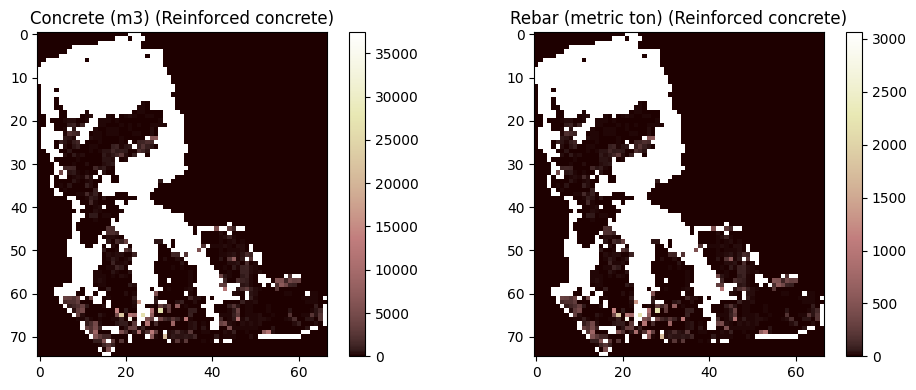

In [115]:
concrete_21_m3

 

plt.figure(figsize=(10,4))
plt.subplot(nrow, ncol, 1)
plt.imshow(concrete_21_m3,  cmap='pink')
plt.colorbar()
plt.title('Concrete (m3) (Reinforced concrete)') 

plt.subplot(nrow, ncol, 2)
plt.imshow(rebar_21_kg /1E3,  cmap='pink')
plt.colorbar()
plt.title('Rebar (metric ton) (Reinforced concrete)')


plt.tight_layout()
plt.show()


In [118]:
print("Concrete for Reinforced concrete  = " + str(np.nansum(concrete_21_m3)) + " (m3)")  
print("Rebar for Reinforced concerete = " + str(np.nansum(rebar_21_kg)/1E3) + " (ton)")   


Concrete for Reinforced concrete  = 930236.043 (m3)
Rebar for Reinforced concerete = 76110.2217 (ton)


MI와 Embedded Carbon사이의 관계식을 엑셀에서 읽어들이고 내재탄소량 계산

MI와 내재탄소량 플로팅